In [1]:
# Import required libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from mrjob.job import MRJob
import geopandas as gpd
from pprint import pprint
import warnings
import seaborn as sns
import mplcursors
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from shapely.geometry import Point, LineString
import folium
from folium.plugins import MarkerCluster
import json
warnings.filterwarnings('ignore')

In [3]:
# Specify file path
zip_file_path = 'C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/Resources/archive.zip'
csv_file_name = 'US_Accidents_March23.csv'

In [4]:
# Extract the CSV file from the zip archive (large file size prevents loading file directly)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name)

In [5]:
# Read the CSV file using Pandas and filter for rows where 'state' = 'CA'
df = pd.read_csv(csv_file_name, 
                 usecols=[0, 2, 4, 7, 8, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 27, 28, 42])

# Convert column names to lowercase
df.columns = df.columns.str.lower()

# Filter for rows where 'state' = 'ca'
df = df[df['state'] == 'CA']

# Convert the 'end_time' column to datetime
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

# Filter the DataFrame for rows where 'end_time' is in the year 2022
df_2022 = df[df['end_time'].dt.year == 2022]

# Display the first few rows of the filtered DataFrame
print(df_2022.head())

              id  severity            end_time  end_lat  end_lng  \
512218  A-512231         1 2022-09-08 04:31:32      NaN      NaN   
512243  A-512257         1 2022-09-08 02:32:20      NaN      NaN   
512262  A-512277         3 2022-09-07 22:38:20      NaN      NaN   
512314  A-512340         2 2022-09-08 02:33:13      NaN      NaN   
512315  A-512341         1 2022-09-08 03:00:27      NaN      NaN   

                                              description           street  \
512218        Crash on CA-138 Pearblossom Hwy at 96th St.  Pearblossom Hwy   
512243  Crash on US-101 Southbound before Exit 44 Moor...           US-101   
512262  #1 lane blocked due to crash on I-5 Northbound...              I-5   
512314  HOV lane blocked due to crash on CA-57 Southbo...            CA-57   
512315                   Crash on Valley View Ave at I-5.   Firestone Blvd   

                    city       county state zipcode  temperature(f)  \
512218        Littlerock  Los Angeles    CA   93543

In [6]:
# Display basic information of the DataFrame
display(df_2022.info())

<class 'pandas.core.frame.DataFrame'>
Index: 266128 entries, 512218 to 5421631
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 266128 non-null  object        
 1   severity           266128 non-null  int64         
 2   end_time           266128 non-null  datetime64[ns]
 3   end_lat            229151 non-null  float64       
 4   end_lng            229151 non-null  float64       
 5   description        266128 non-null  object        
 6   street             264969 non-null  object        
 7   city               266127 non-null  object        
 8   county             266128 non-null  object        
 9   state              266128 non-null  object        
 10  zipcode            266065 non-null  object        
 11  temperature(f)     259396 non-null  float64       
 12  wind_chill(f)      256768 non-null  float64       
 13  humidity(%)        259107 non-null  float64

None

In [7]:
# Drop rows with missing values in specific columns
df_2022_cleaned = df_2022.dropna(subset=['end_time', 'end_lat', 'end_lng', 'description', 'street', 'city', 'zipcode', 'temperature(f)', 'visibility(mi)', 'wind_speed(mph)', 'weather_condition', 'sunrise_sunset'])
df_2022_cleaned.head()

,id,severity,end_time,end_lat,end_lng,description,street,city,county,state,zipcode,temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),weather_condition,sunrise_sunset
3677754,A-3705263,2,2022-05-14 12:47:56,34.703485,-120.469720,Incident on MESA CIRCLE DR near HOUSE 3947 Dri...,Mesa Circle Dr,Lompoc,Santa Barbara,CA,93436-1480,70.0,70.0,53.0,29.89,10.0,15.0,0.0,Fair,Day
3677755,A-3705264,2,2022-11-09 08:06:30,33.141815,-117.187222,Slow traffic on CA-78 W from Twin Oaks Valley ...,CA-78 W,San Marcos,San Diego,CA,92069,57.0,57.0,69.0,29.71,10.0,0.0,0.0,Partly Cloudy,Day
3677758,A-3705267,2,2022-09-20 10:08:34,37.250788,-121.906476,Incident on CA-85 NB near CAMDEN AVE Right lan...,Meridian Ave,San Jose,Santa Clara,CA,95118,63.0,63.0,72.0,29.77,10.0,0.0,NaN,Partly Cloudy,Day
3677759,A-3705268,2,2022-04-16 00:34:49,37.250786,-121.906474,Incident on CA-85 NB near CAMDEN AVE Expect de...,CA-85,San Jose,Santa Clara,CA,95118,55.0,55.0,58.0,29.84,10.0,0.0,NaN,Partly Cloudy,Night
3677760,A-3705269,2,2022-12-29 11:04:30,36.548376,-121.909967,Stationary traffic on CA-1 from Camino Del Mon...,Highway 1,Carmel,Monterey,CA,93923,50.0,50.0,93.0,29.70,2.0,5.0,0.0,Light Rain,Day


In [8]:
# Select the 'county' and 'zipcode' columns
county_zipcode_list = df_2022_cleaned[['county', 'zipcode']]

# Truncate 'zipcode' to the first 5 characters
county_zipcode_list['zipcode'] = county_zipcode_list['zipcode'].str[:5]

# Drop duplicates to get unique combinations
county_zipcode_list = county_zipcode_list.drop_duplicates()

# Sort by 'county' and then by 'zipcode'
county_zipcode_list = county_zipcode_list.sort_values(by=['county', 'zipcode'])

# Convert to a list of tuples
county_zipcode_list = list(county_zipcode_list.itertuples(index=False, name=None))

# Display the list of unique combinations
county_zipcode_list

[('Alameda', '94501'),
 ('Alameda', '94502'),
 ('Alameda', '94514'),
 ('Alameda', '94536'),
 ('Alameda', '94538'),
 ('Alameda', '94539'),
 ('Alameda', '94541'),
 ('Alameda', '94542'),
 ('Alameda', '94544'),
 ('Alameda', '94545'),
 ('Alameda', '94546'),
 ('Alameda', '94550'),
 ('Alameda', '94551'),
 ('Alameda', '94552'),
 ('Alameda', '94555'),
 ('Alameda', '94560'),
 ('Alameda', '94566'),
 ('Alameda', '94568'),
 ('Alameda', '94577'),
 ('Alameda', '94578'),
 ('Alameda', '94579'),
 ('Alameda', '94580'),
 ('Alameda', '94586'),
 ('Alameda', '94587'),
 ('Alameda', '94588'),
 ('Alameda', '94601'),
 ('Alameda', '94602'),
 ('Alameda', '94603'),
 ('Alameda', '94605'),
 ('Alameda', '94606'),
 ('Alameda', '94607'),
 ('Alameda', '94608'),
 ('Alameda', '94609'),
 ('Alameda', '94610'),
 ('Alameda', '94611'),
 ('Alameda', '94612'),
 ('Alameda', '94613'),
 ('Alameda', '94618'),
 ('Alameda', '94619'),
 ('Alameda', '94621'),
 ('Alameda', '94702'),
 ('Alameda', '94703'),
 ('Alameda', '94704'),
 ('Alameda'

In [9]:
# Lists of California counties population and drivers
california_counties_population = [
    ("Alameda", 1622188),
    ("Alpine", 1141),
    ("Amador", 41811),
    ("Butte", 207172),
    ("Calaveras", 46565),
    ("Colusa", 22037),
    ("Contra Costa", 1155025),
    ("Del Norte", 26589),
    ("El Dorado", 192215),
    ("Fresno", 1017162),
    ("Glenn", 28129),
    ("Humboldt", 133985),
    ("Imperial", 179057),
    ("Inyo", 18527),
    ("Kern", 913820),
    ("Kings", 152682),
    ("Lake", 67878),
    ("Lassen", 28861),
    ("Los Angeles", 9663345),
    ("Madera", 162858),
    ("Marin", 254407),
    ("Mariposa", 16919),
    ("Mendocino", 89108),
    ("Merced", 291920),
    ("Modoc", 8500),
    ("Mono", 13066),
    ("Monterey", 430723),
    ("Napa", 133216),
    ("Nevada", 102037),
    ("Orange", 3135755),
    ("Placer", 423561),
    ("Plumas", 19131),
    ("Riverside", 2492442),
    ("Sacramento", 1584288),
    ("San Benito", 68175),
    ("San Bernardino", 2195611),
    ("San Diego", 3269973),
    ("San Francisco", 808988),
    ("San Joaquin", 800965),
    ("San Luis Obispo", 281639),
    ("San Mateo", 726353),
    ("Santa Barbara", 441257),
    ("Santa Clara", 1877592),
    ("Santa Cruz", 261547),
    ("Shasta", 180366),
    ("Sierra", 3200),
    ("Siskiyou", 42905),
    ("Solano", 449218),
    ("Sonoma", 481812),
    ("Stanislaus", 551430),
    ("Sutter", 97948),
    ("Tehama", 64896),
    ("Trinity", 15670),
    ("Tulare", 479468),
    ("Tuolumne", 54204),
    ("Ventura", 829590),
    ("Yolo", 220544),
    ("Yuba", 85722)
]

california_counties_drivers = [
    ("Alameda", 1133248),
    ("Alpine", 1152),
    ("Amador", 29584),
    ("Butte", 150472),
    ("Calaveras", 37529),
    ("Colusa", 15061),
    ("Contra Costa", 824776),
    ("Del Norte", 17781),
    ("El Dorado", 152474),
    ("Fresno", 600899),
    ("Glenn", 20461),
    ("Humboldt", 96258),
    ("Imperial", 122431),
    ("Inyo", 14245),
    ("Kern", 531874),
    ("Kings", 79811),
    ("Lake", 46901),
    ("Lassen", 18328),
    ("Los Angeles", 6581750),
    ("Madera", 91756),
    ("Marin", 194988),
    ("Mariposa", 13891),
    ("Mendocino", 65529),
    ("Merced", 163059),
    ("Modoc", 6633),
    ("Mono", 9403),
    ("Monterey", 274211),
    ("Napa", 100786),
    ("Nevada", 83294),
    ("Orange", 2308918),
    ("Placer", 306269),
    ("Plumas", 16201),
    ("Riverside", 1615036),
    ("Sacramento", 1059829),
    ("San Benito", 44703),
    ("San Bernardino", 1425931),
    ("San Diego", 2361084),
    ("San Francisco", 574119),
    ("San Joaquin", 491088),
    ("San Luis Obispo", 203180),
    ("San Mateo", 547328),
    ("Santa Barbara", 292196),
    ("Santa Clara", 1378403),
    ("Santa Cruz", 189420),
    ("Shasta", 133577),
    ("Sierra", 2326),
    ("Siskiyou", 34487),
    ("Solano", 312480),
    ("Sonoma", 361821),
    ("Stanislaus", 355857),
    ("Sutter", 67863),
    ("Tehama", 44151),
    ("Trinity", 9158),
    ("Tulare", 272095),
    ("Tuolumne", 41007),
    ("Ventura", 611327),
    ("Yolo", 139613),
    ("Yuba", 50733)
]

# Convert lists to DataFrames
df_population = pd.DataFrame(california_counties_population, columns=['county', 'population'])
df_drivers = pd.DataFrame(california_counties_drivers, columns=['county', 'licensed_drivers'])

# Merge DataFrames on 'county'
ca_county_data_df = pd.merge(df_population, df_drivers, on='county')

# Display the merged DataFrame
ca_county_data_df.head()

,county,population,licensed_drivers
0,Alameda,1622188,1133248
1,Alpine,1141,1152
2,Amador,41811,29584
3,Butte,207172,150472
4,Calaveras,46565,37529


In [10]:
display(ca_county_data_df.info())
display(df_2022_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   county            58 non-null     object
 1   population        58 non-null     int64 
 2   licensed_drivers  58 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 218591 entries, 3677754 to 5421631
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 218591 non-null  object        
 1   severity           218591 non-null  int64         
 2   end_time           218591 non-null  datetime64[ns]
 3   end_lat            218591 non-null  float64       
 4   end_lng            218591 non-null  float64       
 5   description        218591 non-null  object        
 6   street             218591 non-null  object        
 7   city               218591 non-null  object        
 8   county             218591 non-null  object        
 9   state              218591 non-null  object        
 10  zipcode            218591 non-null  object        
 11  temperature(f)     218591 non-null  float64       
 12  wind_chill(f)      218591 non-null  float64       
 13  humidity(%)        218359 non-null  float6

None

In [11]:
# Merge df_2022_cleaned with ca_county_data_df on 'county'
merged_df = df_2022_cleaned.merge(ca_county_data_df, on='county', how='left')

# Calculate the number of accidents per county
accident_counts = merged_df.groupby('county').size().reset_index(name='accident_count')

# Merge the accident counts back into the merged DataFrame
result_df = merged_df.merge(accident_counts, on='county', how='left')

# Add calculated columns

# Accidents per 100,000 licensed drivers
result_df['accidents_per_100k_drivers'] = (result_df['accident_count'] / result_df['licensed_drivers']) * 100000

# Accidents per 100,000 population
result_df['accidents_per_100k_population'] = (result_df['accident_count'] / result_df['population']) * 100000

# Percentage of licensed drivers involved in accidents
result_df['percent_drivers_involved'] = (result_df['accident_count'] / result_df['licensed_drivers']) * 100

# Display the updated DataFrame
result_df.head()

,id,severity,end_time,end_lat,end_lng,description,street,city,county,state,...,wind_speed(mph),precipitation(in),weather_condition,sunrise_sunset,population,licensed_drivers,accident_count,accidents_per_100k_drivers,accidents_per_100k_population,percent_drivers_involved
0,A-3705263,2,2022-05-14 12:47:56,34.703485,-120.469720,Incident on MESA CIRCLE DR near HOUSE 3947 Dri...,Mesa Circle Dr,Lompoc,Santa Barbara,CA,...,15.0,0.0,Fair,Day,441257,292196,2314,791.934181,524.410944,0.791934
1,A-3705264,2,2022-11-09 08:06:30,33.141815,-117.187222,Slow traffic on CA-78 W from Twin Oaks Valley ...,CA-78 W,San Marcos,San Diego,CA,...,0.0,0.0,Partly Cloudy,Day,3269973,2361084,13959,591.211494,426.884259,0.591211
2,A-3705267,2,2022-09-20 10:08:34,37.250788,-121.906476,Incident on CA-85 NB near CAMDEN AVE Right lan...,Meridian Ave,San Jose,Santa Clara,CA,...,0.0,NaN,Partly Cloudy,Day,1877592,1378403,6765,490.785351,360.301919,0.490785
3,A-3705268,2,2022-04-16 00:34:49,37.250786,-121.906474,Incident on CA-85 NB near CAMDEN AVE Expect de...,CA-85,San Jose,Santa Clara,CA,...,0.0,NaN,Partly Cloudy,Night,1877592,1378403,6765,490.785351,360.301919,0.490785
4,A-3705269,2,2022-12-29 11:04:30,36.548376,-121.909967,Stationary traffic on CA-1 from Camino Del Mon...,Highway 1,Carmel,Monterey,CA,...,5.0,0.0,Light Rain,Day,430723,274211,2855,1041.169027,662.838994,1.041169


In [12]:
display(result_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218591 entries, 0 to 218590
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   id                             218591 non-null  object        
 1   severity                       218591 non-null  int64         
 2   end_time                       218591 non-null  datetime64[ns]
 3   end_lat                        218591 non-null  float64       
 4   end_lng                        218591 non-null  float64       
 5   description                    218591 non-null  object        
 6   street                         218591 non-null  object        
 7   city                           218591 non-null  object        
 8   county                         218591 non-null  object        
 9   state                          218591 non-null  object        
 10  zipcode                        218591 non-null  object        
 11  

None

Enter the name of the county:  San Francisco


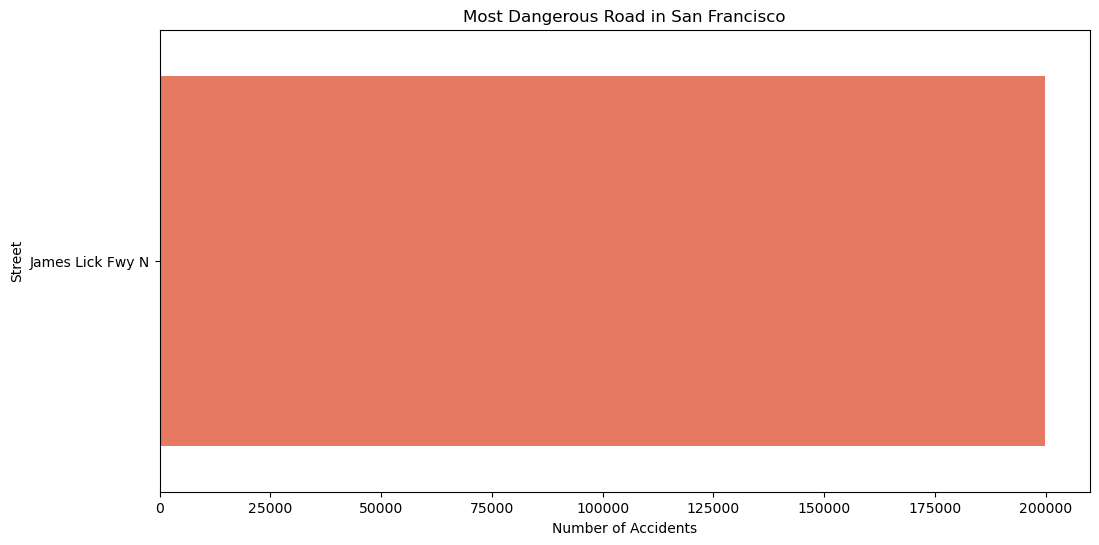

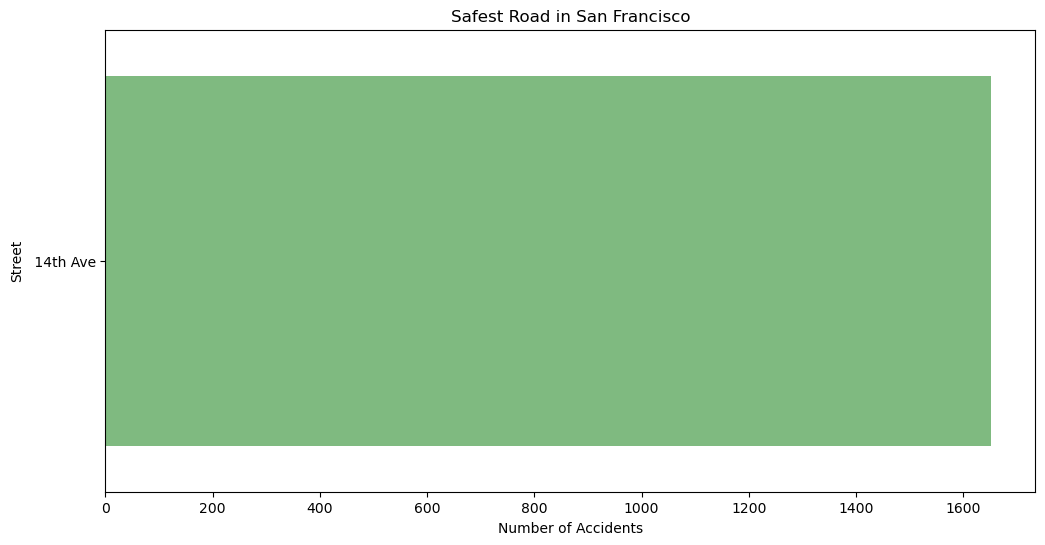

In [20]:
# Function to generate visualizations for a given county
def visualize_roads_by_county(county_name):
    # Filter the data for the specified county
    county_data = result_df[result_df['county'] == county_name]
    
    # Group by street and calculate the total number of accidents
    street_accidents = county_data.groupby('street').agg({'accident_count': 'sum'}).reset_index()
    
    # Find the most dangerous road in the county
    most_dangerous_road = street_accidents.loc[street_accidents['accident_count'].idxmax()]
    
    # Find the safest road in the county
    safest_road = street_accidents.loc[street_accidents['accident_count'].idxmin()]
    
    # Plot the most dangerous road
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='accident_count', y='street', data=street_accidents[street_accidents['street'] == most_dangerous_road['street']], palette='Reds_r')
    plt.title(f'Most Dangerous Road in {county_name}')
    plt.xlabel('Number of Accidents')
    plt.ylabel('Street')
    cursor = mplcursors.cursor(ax, hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(f'Accidents: {sel.target[0]:.0f}'))
    plt.savefig(f'most_dangerous_road_{county_name}.png')
    plt.show()
    
    # Plot the safest road
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='accident_count', y='street', data=street_accidents[street_accidents['street'] == safest_road['street']], palette='Greens_r')
    plt.title(f'Safest Road in {county_name}')
    plt.xlabel('Number of Accidents')
    plt.ylabel('Street')
    cursor = mplcursors.cursor(ax, hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(f'Accidents: {sel.target[0]:.0f}'))
    plt.savefig(f'safest_road_{county_name}.png')
    plt.show()

# Prompt the user to enter a county name
county_name = input("Enter the name of the county: ")

# Generate the visualizations for the specified county
visualize_roads_by_county(county_name)

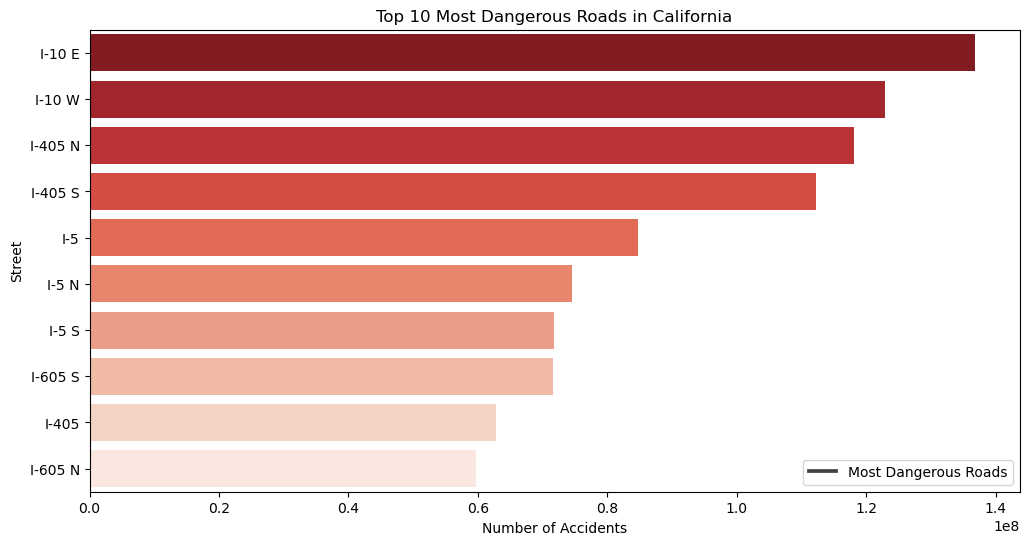

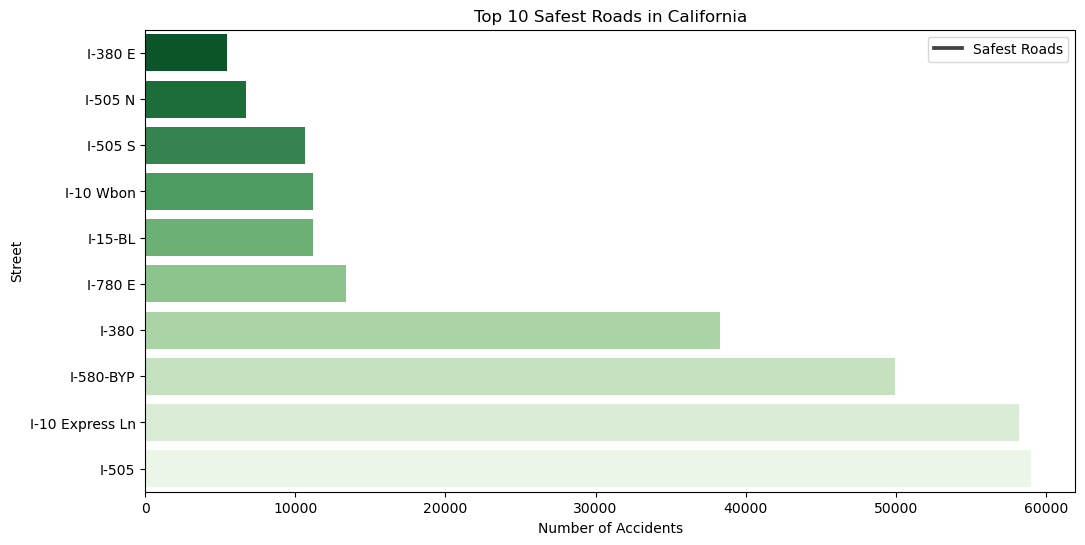

In [21]:
# Filter for state highways and interstate highways
highway_filter = result_df['street'].str.contains(r'\b(I-|CA)\d+', regex=True)
highway_accidents = result_df[highway_filter]

# Group by 'street' and calculate the total number of accidents
street_accidents = highway_accidents.groupby('street').agg({'accident_count': 'sum', 'end_lat': 'first', 'end_lng': 'first'}).reset_index()

# Sort by 'accident_count' to find the most and least dangerous roads
most_dangerous_roads = street_accidents.sort_values(by='accident_count', ascending=False).head(10)
safest_roads = street_accidents.sort_values(by='accident_count', ascending=True).head(10)

# Plot the most dangerous roads
plt.figure(figsize=(12, 6))
sns.barplot(x='accident_count', y='street', data=most_dangerous_roads, palette='Reds_r')
plt.title('Top 10 Most Dangerous Roads in California')
plt.xlabel('Number of Accidents')
plt.ylabel('Street')
plt.legend(['Most Dangerous Roads'])
plt.savefig('top_10_most_dangerous_roads.png')  # Save the plot as an image file
plt.show()

# Plot the safest roads
plt.figure(figsize=(12, 6))
sns.barplot(x='accident_count', y='street', data=safest_roads, palette='Greens_r')
plt.title('Top 10 Safest Roads in California')
plt.xlabel('Number of Accidents')
plt.ylabel('Street')
plt.legend(['Safest Roads'])
plt.savefig('top_10_safest_roads.png')  # Save the plot as an image file
plt.show()

In [22]:
# export top 10s for use in app

# Convert the DataFrames to dictionaries
most_dangerous_roads_dict = most_dangerous_roads.to_dict(orient='records')
safest_roads_dict = safest_roads.to_dict(orient='records')

# Convert Point objects to lists of coordinates
for road in most_dangerous_roads_dict:
    road['end_lat'] = road['end_lat'].y if hasattr(road['end_lat'], 'y') else road['end_lat']
    road['end_lng'] = road['end_lng'].x if hasattr(road['end_lng'], 'x') else road['end_lng']

for road in safest_roads_dict:
    road['end_lat'] = road['end_lat'].y if hasattr(road['end_lat'], 'y') else road['end_lat']
    road['end_lng'] = road['end_lng'].x if hasattr(road['end_lng'], 'x') else road['end_lng']

# Save the dictionaries to JSON files
with open('most_dangerous_roads.json', 'w') as f:
    json.dump(most_dangerous_roads_dict, f)

with open('safest_roads.json', 'w') as f:
    json.dump(safest_roads_dict, f)

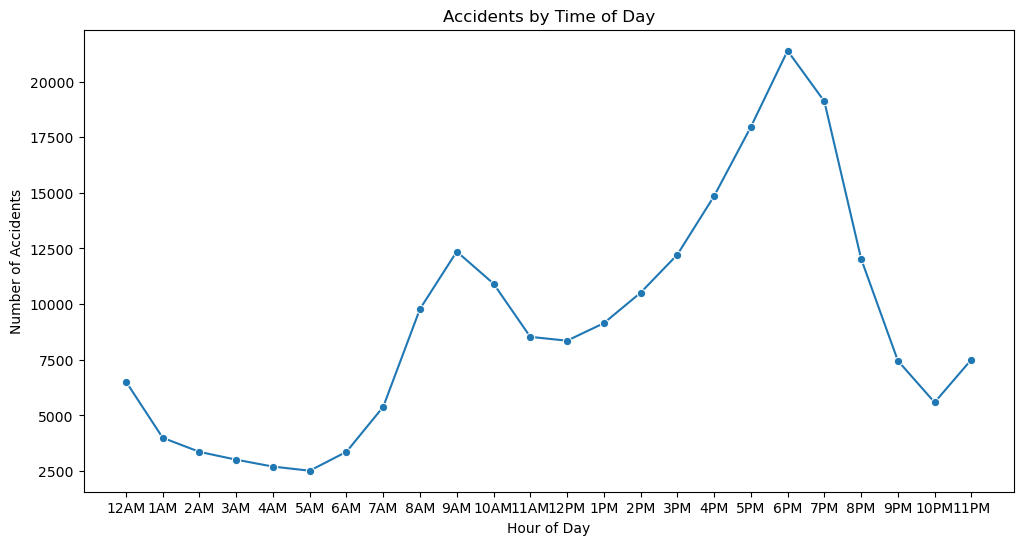

In [29]:
# Accidents by Time of Day

# Extract hour from end_time
result_df['hour'] = result_df['end_time'].dt.hour

# Group by hour and count accidents
accidents_by_hour = result_df.groupby('hour').size().reset_index(name='accident_count')

# Convert hour to AM/PM format
hour_labels = {0: '12AM', 1: '1AM', 2: '2AM', 3: '3AM', 4: '4AM', 5: '5AM', 6: '6AM', 7: '7AM', 8: '8AM', 9: '9AM', 10: '10AM', 11: '11AM', 12: '12PM', 13: '1PM', 14: '2PM', 15: '3PM', 16: '4PM', 17: '5PM', 18: '6PM', 19: '7PM', 20: '8PM', 21: '9PM', 22: '10PM', 23: '11PM'}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='accident_count', data=accidents_by_hour, marker='o', palette='viridis')
plt.title('Accidents by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(0, 24), labels=[hour_labels[hour] for hour in range(0, 24)])
plt.savefig('accidents_by_hour_line_chart.png')
plt.show()

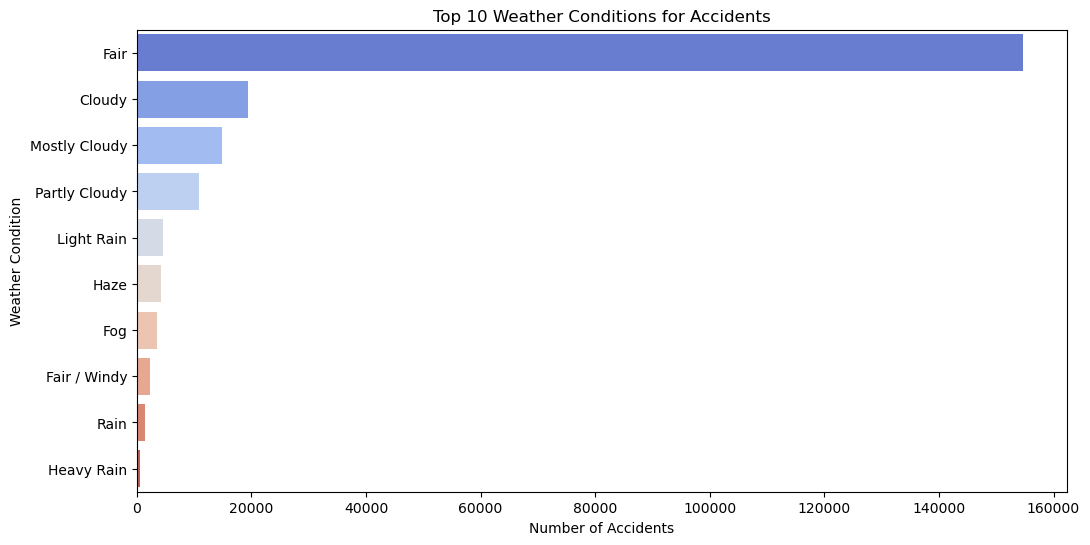

In [30]:
# Accidents by Weather Condition

# Group by weather_condition and count accidents
accidents_by_weather = result_df.groupby('weather_condition').size().reset_index(name='accident_count')

# Get top 10 weather conditions
top_10_weather = accidents_by_weather.nlargest(10, 'accident_count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='accident_count', y='weather_condition', data=top_10_weather, palette='coolwarm')
plt.title('Top 10 Weather Conditions for Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.savefig('accidents_by_weather.png')
plt.show()

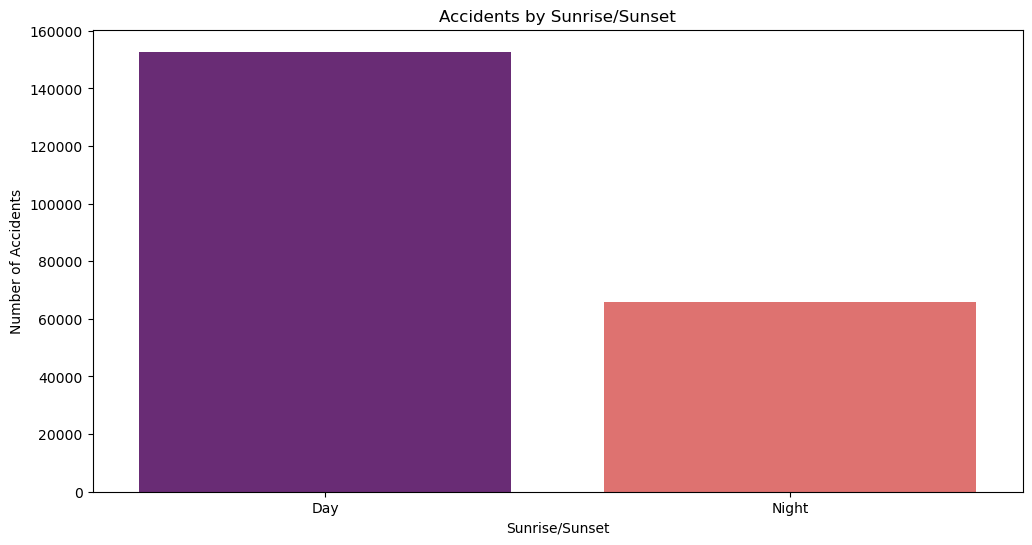

In [31]:
# Accidents by Sunrise/Sunset
# Group by sunrise_sunset and count accidents
accidents_by_sunrise_sunset = result_df.groupby('sunrise_sunset').size().reset_index(name='accident_count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='sunrise_sunset', y='accident_count', data=accidents_by_sunrise_sunset, palette='magma')
plt.title('Accidents by Sunrise/Sunset')
plt.xlabel('Sunrise/Sunset')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_sunrise_sunset.png')
plt.show()

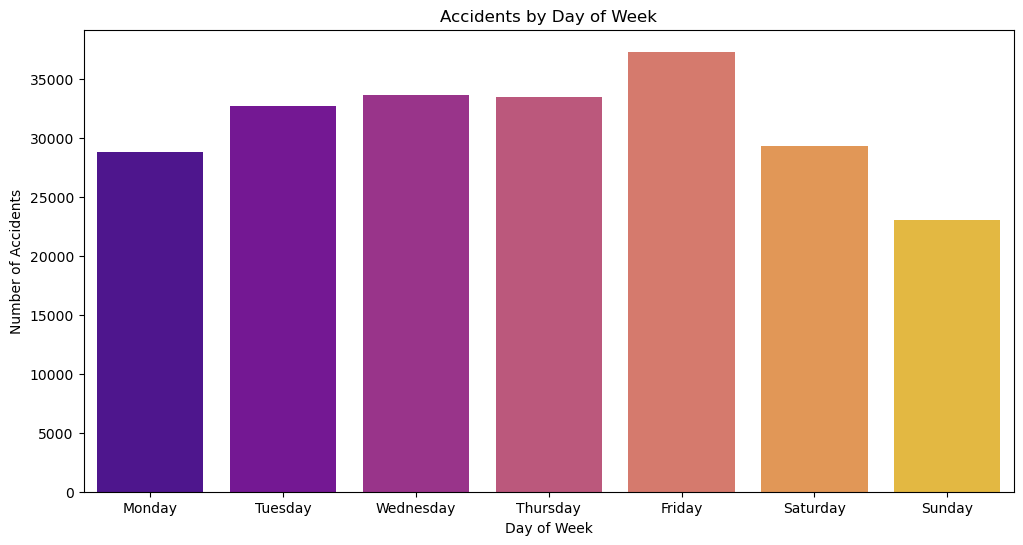

In [32]:
# Accidents by Day of Week
# Extract day of week from end_time
result_df['day_of_week'] = result_df['end_time'].dt.day_name()

# Group by day_of_week and count accidents
accidents_by_day = result_df.groupby('day_of_week').size().reset_index(name='accident_count')

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
accidents_by_day['day_of_week'] = pd.Categorical(accidents_by_day['day_of_week'], categories=days_order, ordered=True)
accidents_by_day = accidents_by_day.sort_values('day_of_week')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='accident_count', data=accidents_by_day, palette='plasma')
plt.title('Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_day.png')
plt.show()

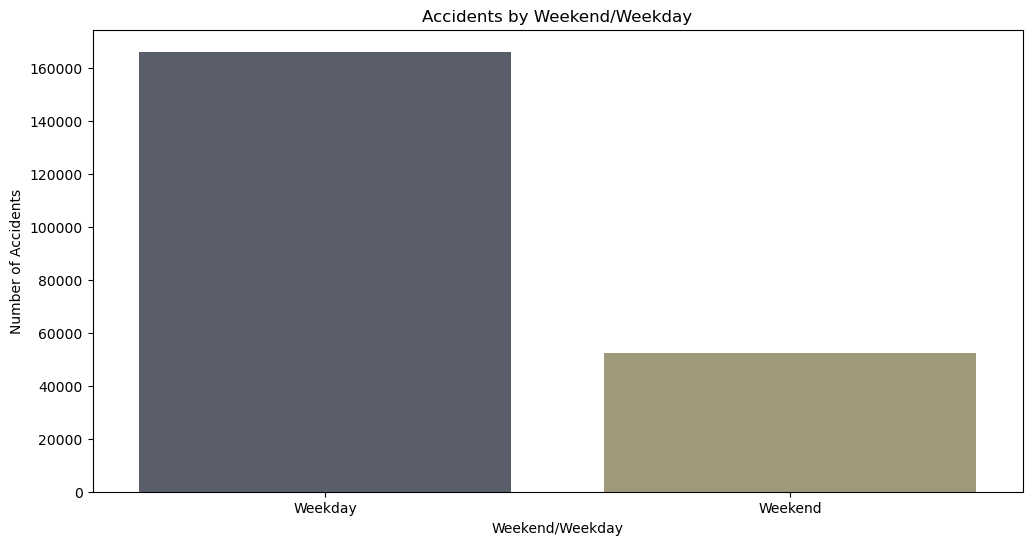

In [33]:
# Accidents by Weekend/Weekday
# Determine if the day is a weekend or weekday
result_df['is_weekend'] = result_df['end_time'].dt.dayofweek >= 5

# Group by is_weekend and count accidents
accidents_by_weekend = result_df.groupby('is_weekend').size().reset_index(name='accident_count')
accidents_by_weekend['is_weekend'] = accidents_by_weekend['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='is_weekend', y='accident_count', data=accidents_by_weekend, palette='cividis')
plt.title('Accidents by Weekend/Weekday')
plt.xlabel('Weekend/Weekday')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_weekend.png')
plt.show()


In [ ]:
fatal_df = pd.read_csv('fatal_accident_df.csv')
fatal_df.head()

In [ ]:
display(df_2022_cleaned.info())

In [ ]:
display(fatal_df.info())

In [ ]:
# Calculate the number of fatal accidents per state
fatal_accidents_per_state = fatal_df.groupby('STATENAME')['ST_CASE'].nunique().reset_index()
fatal_accidents_per_state.columns = ['state', 'fatal_accidents']

# Plot the data
plt.figure(figsize=(14, 8))
sns.barplot(x='state', y='fatal_accidents', data=fatal_accidents_per_state, palette='viridis')
plt.title('Fatal Accidents per State in 2022')
plt.xlabel('State')
plt.ylabel('Number of Fatal Accidents')
plt.xticks(rotation=90)
plt.savefig('fatal_accidents_per_state.png')
plt.show()